## QD blinking line-repetition simulation
Simulating imaging of QDs including brightness and blinking with different line-repetition acquisition modes.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import scipy.stats as st
from PIL import Image

def gkern(kernlen=21, std=3):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    return mask

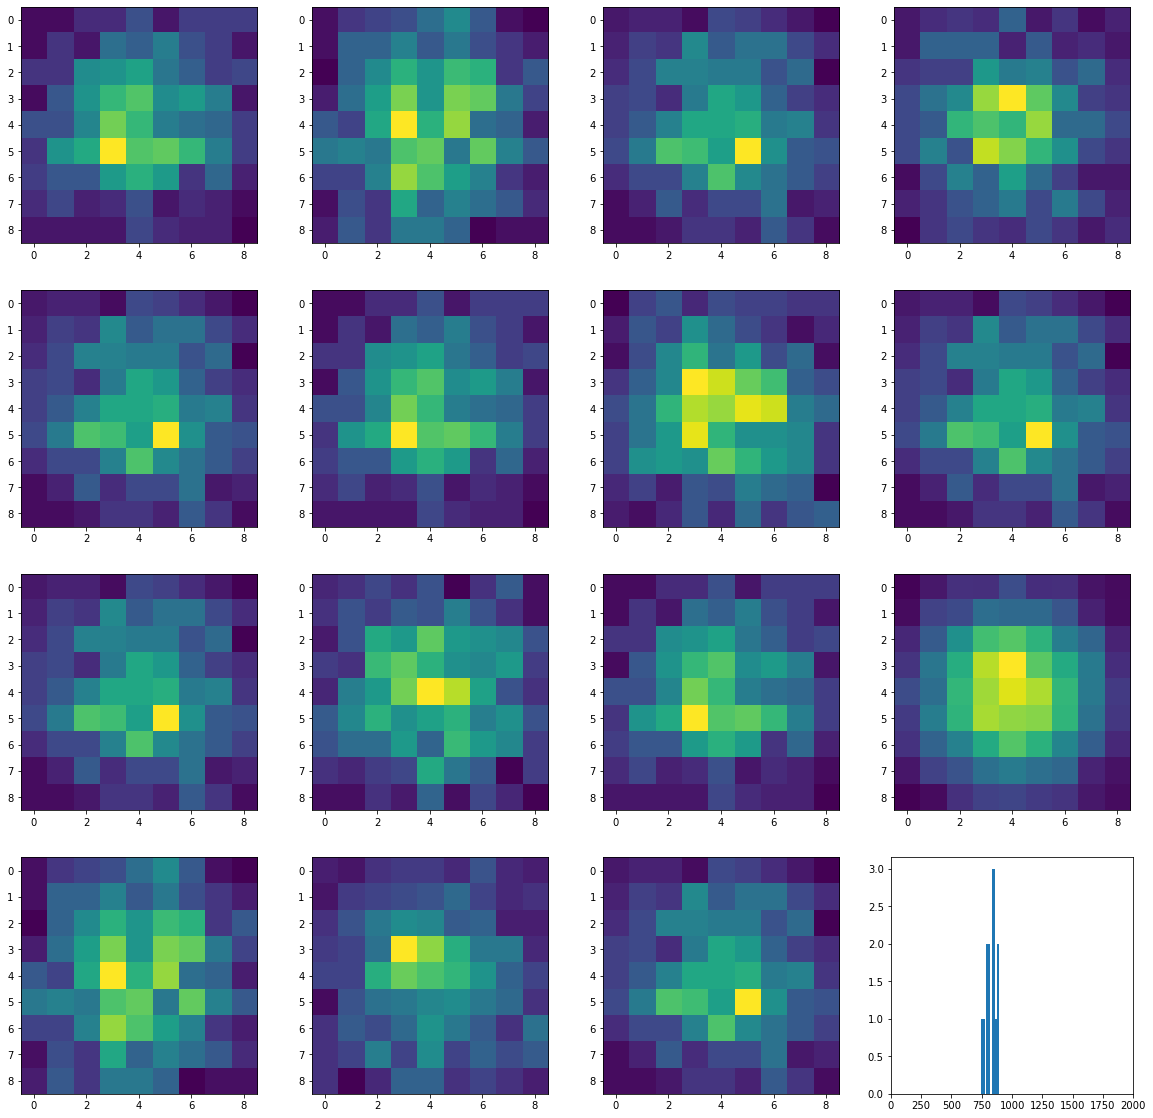

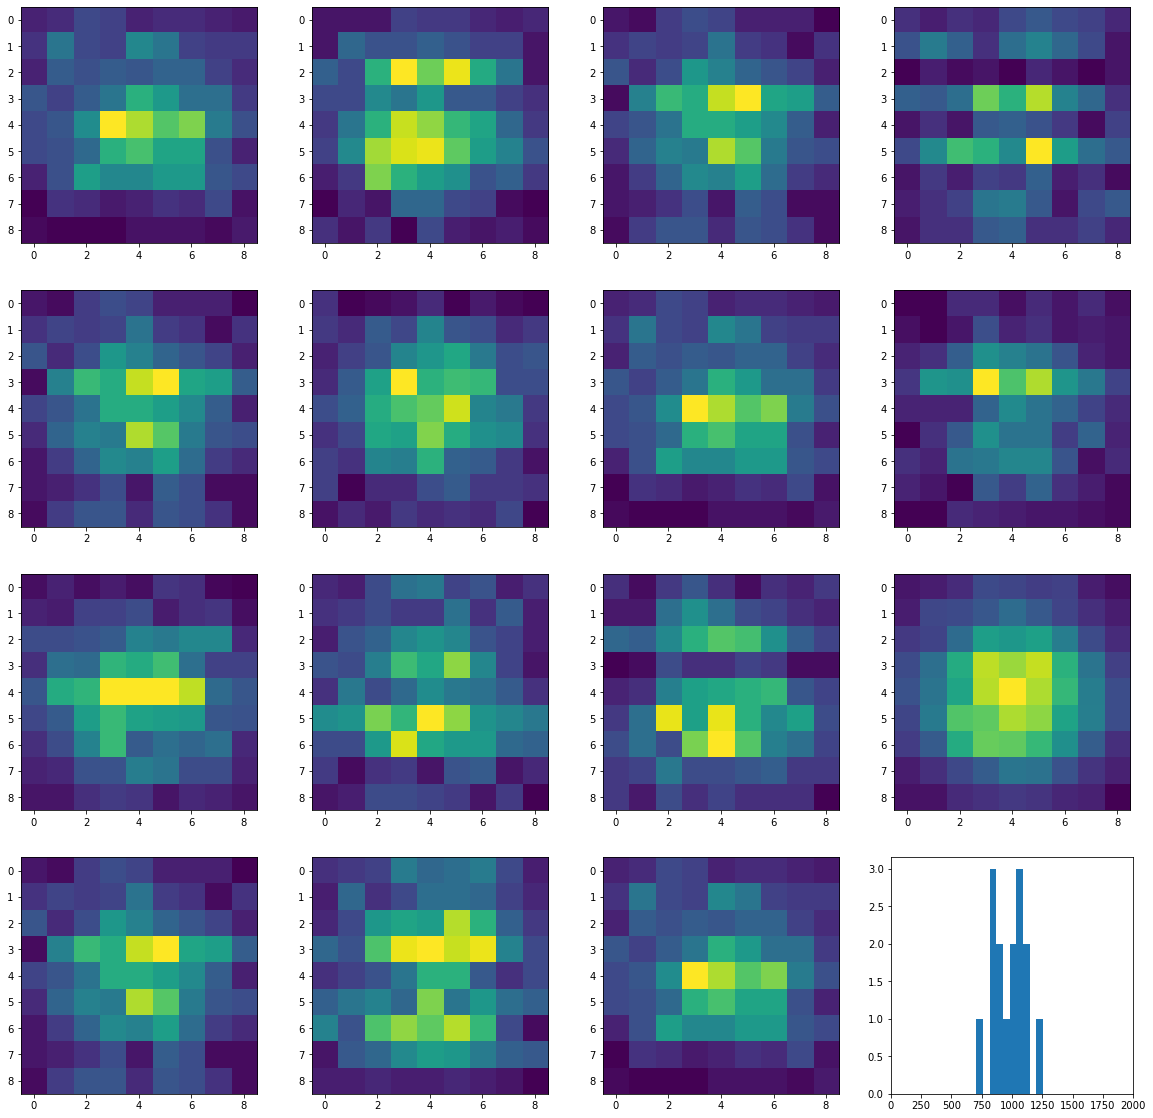

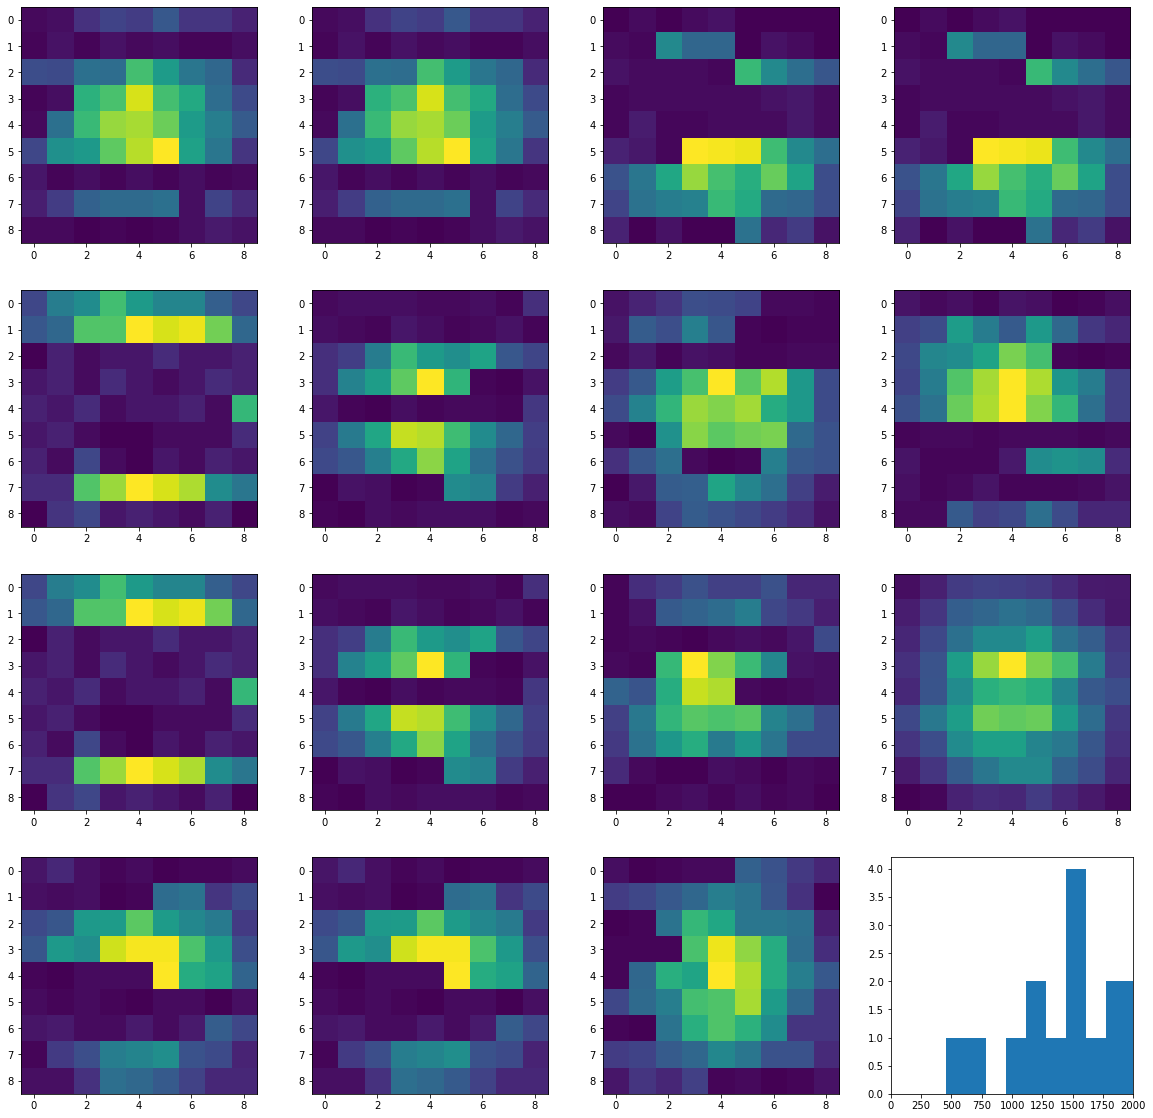

In [5]:
# general params
dts = [2,20,200]  # single pixel dwell times in time units, all to try
tot_dt = 200  # total pixel dwell time in time units
img_size_m = 0.27  # image size in µm
px_size = 0.03  # pixel size in µm
img_size = int(img_size_m / px_size)  # image size in pixels
qd_size_m = 0.07  # size of imaged qd in µm (std width)
qd_size = qd_size_m / px_size  # size of qd in pixels (std width)
i_rate = 0.36  # qd brightness in intensity units
qd_repetitions = 15  # number of qds to simulate per time
bkg_rate = 1/100  # bkg in intensity units
off_time = 700  # mean off time in time units
on_time = 1000  # mean on time in time units
std_onoff_time = 2000  # std on/off time in time units
blink_sim_factor = 8  # factor of overshoot blinking to then take the middle part

qd_img_all_all_dts = []

for dt in dts:
    # general params
    line_reps = int(tot_dt/dt)  # number of line reps
    # for ideal qd image
    i_max = dt * i_rate  # maximum intensity of qd in a pixel
    # for bkg
    bkg_mean = dt * bkg_rate  # mean poissonion bkg
    # for blinking
    off_time_px = off_time / dt  # mean off time in pixels
    on_time_px = on_time / dt  # mean off time in pixels
    std_onoff_time_px = std_onoff_time / dt  # std on/off time in pixels

    # generate raw qd image without noise, blinking or bkg
    qd_raw = gkern(img_size, std=qd_size)*i_max

    # create empty list for all qd images
    qd_img_all = []

    for qdnum in range(qd_repetitions):
        # create empty list for all qd image repetitions for a single qd
        qd_img_reps = []
        for rep in range(line_reps):
            # generate on/off mask of QD blinking
            on_off_mask = []
            for line in range(img_size):
                line_signal = np.array([])
                state = np.random.randint(0,1)
                while len(line_signal) < img_size * blink_sim_factor:
                    if state == 1:
                        mean_time = on_time_px
                    elif state == 0:
                        mean_time = off_time_px
                    # if wanting gaussian on/off time:
                    new_signal_len = np.random.normal(loc=mean_time, scale=std_onoff_time_px)
                    new_signal_len = np.max([new_signal_len,0])
                    # if wanting poisson on/off time:
                    #rng = np.random.default_rng()
                    #new_signal_len = rng.poisson(lam=mean_time)
                    new_signal = np.ones(int(np.floor(new_signal_len))) * state
                    line_signal = np.append(line_signal, new_signal)
                    if new_signal_len != 1:
                        if state == 1:
                            state = 0
                        elif state == 0:
                            state = 1
                line_signal = line_signal[int(img_size * blink_sim_factor / 2 - img_size/2):int(img_size * blink_sim_factor / 2 + img_size/2)]
                on_off_mask.append(line_signal)
            on_off_mask = np.array(on_off_mask)

            # generate blinking qd image without noise or bkg
            qd_blink = qd_raw * on_off_mask

            # generate noisy raw qd image
            qd_poiss = np.random.poisson(qd_blink)

            # generate bkg carpet and add to qd_img
            rng = np.random.default_rng()
            bkg = rng.poisson(lam=bkg_mean, size=np.shape(qd_raw))
            qd_img = qd_poiss + bkg  # include bkg
            #qd_img = qd_poiss  # no bkg

            # add qd_img to array of repetition images
            qd_img_reps.append(qd_img)

        qd_img_tot = np.sum(qd_img_reps,axis=0)

        qd_img_all.append(qd_img_tot)

    qd_img_intsums = [np.sum(qdimg) for qdimg in qd_img_all]

    ## plt qd images
    #fig, ax = plt.subplots(1,5, figsize=(25,7))
    #ax[0].imshow(qd_raw)
    #ax[1].imshow(on_off_mask)
    #ax[2].imshow(qd_img)
    #ax[3].imshow(qd_img_tot)
    #ax[4].hist(qd_img_intsums)
    
    # plot a selection of generated qd images
    numplots = 16
    nums = [num for num in range(numplots)]
    plotx = [int(num % np.sqrt(numplots)) for num in nums]
    ploty = [int(int(num/np.sqrt(numplots)) % np.sqrt(numplots)) for num in nums]
    fig, ax = plt.subplots(int(np.sqrt(numplots)),int(np.sqrt(numplots)), figsize=(20,20))
    for i in range(numplots):
        plotpos = (plotx[i],ploty[i])
        if i < numplots-2:
            randqd = np.random.randint(0,qd_repetitions-1)
            ax[plotpos[0],plotpos[1]].imshow(qd_img_all[randqd])
        elif i == numplots - 2:
            meanqd = np.mean(qd_img_all,axis=0)
            ax[plotpos[0],plotpos[1]].imshow(meanqd)
        elif i == numplots-1:
            ax[plotpos[0],plotpos[1]].hist(qd_img_intsums)
            ax[plotpos[0],plotpos[1]].set_xlim(0,2000)
    
    plt.show()
    
    qd_img_all_all_dts.append(qd_img_all)

In [6]:
# blinking pixel ratio
blinkratios_all = []
intensities_all = []
circ_mask = create_circular_mask(img_size,img_size,radius=3)
for idx,dt in enumerate(dts):
    blinkratios_all.append([])
    intensities_all.append([])
    qd_img_all = qd_img_all_all_dts[idx]
    meanqd = np.mean(qd_img_all,axis=0)
    poissonnoise = np.sqrt(meanqd)
    mean_minus_poisson = meanqd - poissonnoise
    mean_minus_poisson[mean_minus_poisson < 0] = 0
    for qd in qd_img_all:
        blinkmask = qd < mean_minus_poisson
        blinkmask = blinkmask*circ_mask
        blinkratio = np.sum(blinkmask)/np.sum(circ_mask)
        blinkratios_all[idx].append(blinkratio)
        
        brightness = np.sum(qd * circ_mask)
        # brightness = np.sum(qd)
        intensities_all[idx].append(brightness)
        
mean_blinkratios = np.mean(blinkratios_all,axis=1)
for idx,dt in enumerate(dts):
    print(f'Mean blinking pixel ratio, dt = {dt} µs: {mean_blinkratios[idx]:.2f}')
    
print('')
mean_brightness = np.mean(intensities_all,axis=1)
for idx,dt in enumerate(dts):
    print(f'Mean brightness, dt = {dt} µs: {mean_brightness[idx]:.2f}')

Mean blinking pixel ratio, dt = 2 µs: 0.17
Mean blinking pixel ratio, dt = 20 µs: 0.30
Mean blinking pixel ratio, dt = 200 µs: 0.43

Mean brightness, dt = 2 µs: 487.73
Mean brightness, dt = 20 µs: 591.80
Mean brightness, dt = 200 µs: 849.60


In [7]:
print(st.kstest(blinkratios_all[0],blinkratios_all[1]).pvalue)
print(st.kstest(blinkratios_all[0],blinkratios_all[2]).pvalue)
print(st.kstest(blinkratios_all[1],blinkratios_all[2]).pvalue)
print('')
print(st.kstest(intensities_all[0],intensities_all[1]).pvalue)
print(st.kstest(intensities_all[0],intensities_all[2]).pvalue)
print(st.kstest(intensities_all[1],intensities_all[2]).pvalue)

0.026248485664288602
0.00035334499932696196
0.18441617684449832

0.007655808318750842
5.2347407307698066e-05
0.007655808318750842


Text(0.5, 0, 'Blinking ratio [a.u.]')

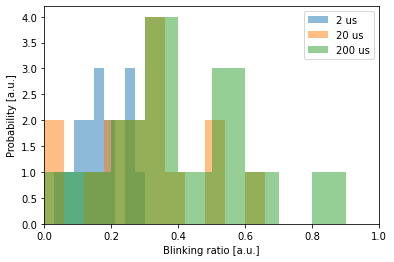

In [83]:
fig = plt.figure()
bins1 = np.arange(0,1,0.03)
plt.hist(blinkratios_all[0], bins=bins1, alpha=0.5)
bins2 = np.arange(0,1,0.06)
plt.hist(blinkratios_all[1], bins=bins2, alpha=0.5)
bins3 = np.arange(0,1,0.1)
plt.hist(blinkratios_all[2], bins=bins3, alpha=0.5)
plt.xlim([0,1])
plt.legend(['2 us','20 us','200 us'])
plt.ylabel('Probability [a.u.]')
plt.xlabel('Blinking ratio [a.u.]')
#plt.savefig('sim-blinkratio.svg')

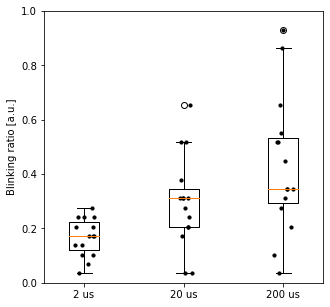

In [139]:
fig = plt.figure(figsize=(5,5))
x1 = 1*np.ones(len(blinkratios_all[0])) + np.random.rand(len(blinkratios_all[0]))*0.1 - 0.05
plt.scatter(x1, blinkratios_all[0], color='k', s=10)
plt.boxplot(blinkratios_all[0], positions=[1])
x2 = 1.5*np.ones(len(blinkratios_all[0])) + np.random.rand(len(blinkratios_all[0]))*0.1 - 0.05
plt.scatter(x2, blinkratios_all[1], color='k', s=10)
plt.boxplot(blinkratios_all[1], positions=[1.5])
x3 = 2*np.ones(len(blinkratios_all[0])) + np.random.rand(len(blinkratios_all[0]))*0.1 - 0.05
plt.scatter(x3, blinkratios_all[2], color='k', s=10)
plt.boxplot(blinkratios_all[2], positions=[2])
plt.xlim([0.8,2.2])
plt.xticks([1,1.5,2],['2 us','20 us','200 us'])
plt.ylim([0,1])
plt.ylabel('Blinking ratio [a.u.]')
plt.savefig('sim-blinkratio-boxplot.svg')

In [80]:
fig = plt.figure()
bins1 = np.arange(0,1600,20)
plt.hist(intensities_all[0], bins=bins1, alpha=0.5)
bins2 = np.arange(0,1600,40)
plt.hist(intensities_all[1], bins=bins2, alpha=0.5)
bins3 = np.arange(0,1600,150)
plt.hist(intensities_all[2], bins=bins3, alpha=0.5)
plt.xlim([0,1600])
plt.ylabel('Probability [a.u.]')
plt.xlabel('Intensity [cnts]')
plt.legend(['2 us','20 us','200 us'])
#plt.savefig('sim-brightness.svg')

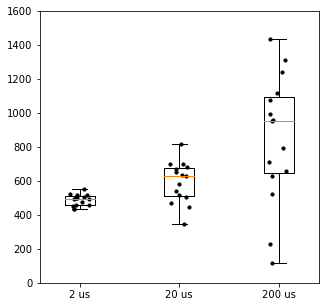

In [140]:
fig = plt.figure(figsize=(5,5))
x1 = 1*np.ones(len(intensities_all[0])) + np.random.rand(len(intensities_all[0]))*0.1 - 0.05
plt.scatter(x1, intensities_all[0], color='k', s=10)
plt.boxplot(intensities_all[0], positions=[1])
x2 = 1.5*np.ones(len(intensities_all[0])) + np.random.rand(len(intensities_all[0]))*0.1 - 0.05
plt.scatter(x2, intensities_all[1], color='k', s=10)
plt.boxplot(intensities_all[1], positions=[1.5])
x3 = 2*np.ones(len(intensities_all[0])) + np.random.rand(len(intensities_all[0]))*0.1 - 0.05
plt.scatter(x3, intensities_all[2], color='k', s=10)
plt.boxplot(intensities_all[2], positions=[2])
plt.xlim([0.8,2.2])
plt.xticks([1,1.5,2],['2 us','20 us','200 us'])
plt.ylim([0,1600])
plt.savefig('sim-brightness-boxplot.svg')

In [206]:
if False:
    pd.DataFrame(blinkratios_all[0]).to_csv("qds_blinkingpixelratio_lines100.csv")
    pd.DataFrame(blinkratios_all[1]).to_csv("qds_blinkingpixelratio_lines10.csv")
    pd.DataFrame(blinkratios_all[2]).to_csv("qds_blinkingpixelratio_lines1.csv")

    pd.DataFrame(intensities_all[0]).to_csv("qds_brightness_lines100.csv")
    pd.DataFrame(intensities_all[1]).to_csv("qds_brightness_lines10.csv")
    pd.DataFrame(intensities_all[2]).to_csv("qds_brightness_lines1.csv")

In [31]:
for idx, dt in enumerate(qd_img_all_all_dts):
    print(dts[idx])
    for idximg, img in enumerate(dt):
        img_savename = 'dt' + str(dts[idx]) + 'us-img' + str(idximg+1).zfill(3) + '.tif'
        im = Image.fromarray(img.astype('uint8'))
        im.save(img_savename)

2
20
200
